# Test and results.

In [11]:
from Markovify.Markovify import Markovify
from Markovify.Utils.CrossValidation import cross_validation_score

from nltk.corpus import brown

import pandas as pd
import numpy as np
import random
from math import ceil
import importlib

from Markovify.Utils.ProgressBar import log_progress

# Accuracy for news text.

In [2]:
corpus = brown.tagged_sents(categories='news', tagset='universal')

model = Markovify(smoothing='max')
brown_news_accuracy = cross_validation_score(model, sentences=corpus, cv=10, verbose=False)
print(brown_news_accuracy)
print('Best accuracy: {}.'.format(np.max(brown_news_accuracy)))

[0.94102921 0.94231366 0.93191749 0.94275454 0.9488     0.94695835
 0.92748337 0.93445535 0.91749021 0.92883485]
Best accuracy: 0.9488.


In [3]:
sample_idx = random.sample(range(0, len(corpus)), ceil(len(corpus) * 0.2))
sample_corpus = list(corpus[i] for i in sample_idx)

nfolds = [3, 5, 10]
scores = []
for n in log_progress(nfolds):
    model = Markovify(smoothing='max')
    score = cross_validation_score(model, sentences=sample_corpus, cv=n, verbose=False)
    scores.append(np.max(score))
    
print(scores)

[0.8890735983073901, 0.9009642950221527, 0.9089935760171306]


# Comparison of different smoothings.

In [4]:
corpus = brown.tagged_sents(categories='news', tagset='universal')

model_laplace = Markovify(smoothing='laplace', alpha=1)
brown_news_accuracy_laplace = cross_validation_score(model_laplace, sentences=corpus, verbose=False)
print('Best accuracy for Laplace smoothing: {}.'.format(np.max(brown_news_accuracy_laplace)))

model_max = Markovify(smoothing='max')
brown_news_accuracy_max = cross_validation_score(model_max, sentences=corpus, verbose=False)
print('Best accuracy for most probable tag: {}.'.format(np.max(brown_news_accuracy_max)))

Best accuracy for Laplace smoothing: 0.9161208329259947.
Best accuracy for most probable tag: 0.9444305631902453.


# Accuracy for news text training the model using an adventures book.

In [2]:
corpus_advs = brown.tagged_sents(categories='adventure', tagset='universal')
corpus_news = brown.tagged_sents(categories='news', tagset='universal')

model = Markovify(smoothing='max')
model = model.fit(corpus_news)

tagged = model.predict(corpus_advs)

In [3]:
advs_records = [item for sublist in corpus_advs for item in sublist]
predicted_tags = [item for sublist in tagged for item in sublist]

results = pd.DataFrame.from_records(advs_records)
results.columns = ["Word", "Tag"]
results['Predicted'] = predicted_tags
results.head(10)

,Word,Tag,Predicted
0,Dan,NOUN,NOUN
1,Morgan,NOUN,NOUN
2,told,VERB,VERB
3,himself,PRON,PRON
4,he,PRON,PRON
5,would,VERB,VERB
6,forget,VERB,VERB
7,Ann,NOUN,NOUN
8,Turner,NOUN,NOUN
9,.,.,.


In [4]:
from Markovify.Utils.Scoring import *

cm = confusion_matrix(corpus_advs, tagged)

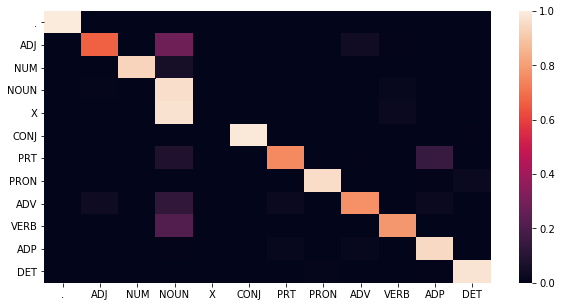

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.rcParams['figure.figsize'] = [10, 5]

sn.heatmap(cm)

In [9]:
print(accuracy(corpus_advs, tagged))
print(recall(corpus_advs, tagged))
print(precision(corpus_advs, tagged))

0.9071125724669031
0.9071125724669031
0.8490028100090127


# Accuracy of the model based on the size of the training corpus.

In [23]:
corpus = brown.tagged_sents(categories='adventure', tagset='universal')

corpus_len = len(corpus)
train_size = [  1 * corpus_len / 100, 
                5 * corpus_len / 100, 
               10 * corpus_len / 100, 
               25 * corpus_len / 100, 
               50 * corpus_len / 100, 
               80 * corpus_len / 100, 
              100 * corpus_len / 100]

accuracies = []
for length in log_progress(train_size):
    partial_corpus = list(corpus[i] for i in range(0, ceil(length)))

    m = Markovify(smoothing='max')
    fold_accuracy = cross_validation_score(m, sentences=partial_corpus)
    accuracies.append(np.max(fold_accuracy))
    
print(accuracies)



[0.6730769230769231, 0.8861209964412812, 0.8767123287671232, 0.890598862495818, 0.9246090534979424, 0.9353300860192766, 0.9406935835148266]


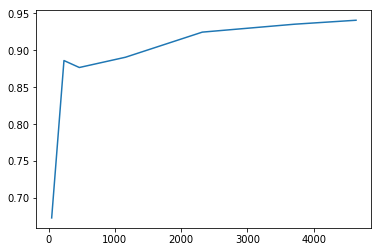

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(train_size, accuracies)

In [12]:
corpus = brown.tagged_sents(categories='adventure', tagset='universal')

m = Markovify(smoothing='max')
acc, m = cross_validation_score(m, sentences=corpus, return_model=True)

Text(0.5,0,'Recuento del tag')

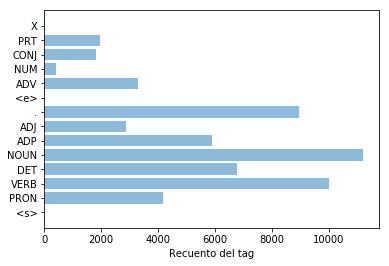

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

tags = m.hmm.q
pos = np.arange(len(tags))
counts = m.hmm.tag_count

plt.barh(pos, counts, align='center', alpha=0.5)
plt.yticks(pos, tags)
plt.xlabel('Recuento del tag')

In [15]:
counts

array([    0.,  4160., 10024.,  6776., 11216.,  5910.,  2882.,  8964.,
           0.,  3289.,   394.,  1805.,  1950.,    34.])